In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score as ami

# Adjusted Mutual Information

Here, we simulate a survey where there are two questions - the first question
has four possible answers - A, B, C, or D. Another question is a satisfaction
score - which is "Very Satisfied", "Neutral" or "Very Dissatisfied". We 
engineer the survey responses such that $P(Satisfied|A) = 80%$, and otherwise 
there is no correlation between A, B, C, or D and satisfaction.


In [2]:
survey = []
alpha = None
for i in range (1000):
  satisfaction = np.random.choice(["Very Satisfied", "Neutral", "Very Dissatisfied"])
  
  # Now, we introduce non random correlation with Very Satisfied
  if satisfaction == "Very Satisfied":
    if np.random.rand() >= 0.2:
      alpha = "A"
  else:
    alpha = np.random.choice(['A','B','C','D'])
  # Note that alpha can be 'A' randomly - this introduces some noise. Sometimes,
  # "Very Satisfied" and "A" coincide by random chance - even though the "true"
  # distribution that characterizes the dependence between "Very Satisfied" and
  # "A" is 80% probability. The difference between the true probability and the
  # measured probability when we use a model is called "irreducible error".
  survey.append((alpha, satisfaction))

In [3]:
# For ease of making plots
results = pd.DataFrame(survey, columns=["Q1", "Satisfaction"])

In [4]:
# Summarize Conditional Probabilities
probabilities = results.groupby('Satisfaction')['Q1'].value_counts() / results.groupby('Satisfaction')['Q1'].count()
probabilities = probabilities.rename('probability').reset_index().sort_values(by=['Satisfaction','Q1'])

In [5]:
probabilities

,Satisfaction,Q1,probability
0,Neutral,A,0.253602
3,Neutral,B,0.244957
1,Neutral,C,0.253602
2,Neutral,D,0.247839
6,Very Dissatisfied,A,0.233766
4,Very Dissatisfied,B,0.288961
5,Very Dissatisfied,C,0.253247
7,Very Dissatisfied,D,0.224026
8,Very Satisfied,A,0.886957
10,Very Satisfied,B,0.037681


/home/mikebeaumier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


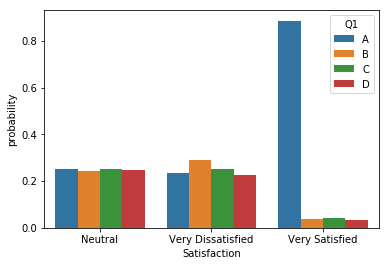

In [6]:
sns.barplot(data=probabilities, x='Satisfaction', y='probability', hue='Q1')

Note above that due to sampling (which exists in the real world) we don't recover the exact probabilities of the underlying probability structure. In this case, we know that $P(Q_{1}\vert Neutral)$ is uniformly distributed, but you can see in the data that there are variations that seem to indicate that the probabilities are slightly different. We can never be perfect in this respect, which is why we must always hold ourselves accountable with confidence intervals, power analyses, and other tools that help us understand how confident we can be in our results, given our data.

# Calculate Mutual Information

We can calculate the mutual information for discrete variables using the formula defined as:

$${I} (X;Y)=\sum _{y\in {\mathcal {Y}}}\sum _{x\in {\mathcal {X}}}{p_{(X,Y)}(x,y)\log {\left({\frac {p_{(X,Y)}(x,y)}{p_{X}(x)\,p_{Y}(y)}}\right)}}$$

Where  $p_{(X,Y)}$ is the joint probability mass function for $X$ and $Y$ and  $p_{X}$ and $p_{Y}$ are the marginal probability distributions.

The joint probability distribution associating two discrete random variables can be thought of as a look up table that returns the probability of all combinations of the values the variables can take on.

The marginal distribution is obtained from the joint by:

<table class="wikitable" style="text-align: center; width:350px; margin: 1em auto 1em auto;">
<tbody><tr>
<th style="background:linear-gradient(to top right,#eaecf0 49.5%,#aaa 49.5%,#aaa 50.5%,#eaecf0 50.5%);line-height:1;"><div style="margin-left:2em;text-align:right;"><i>X</i></div><div style="margin-right:2em;text-align:left;"><i>Y</i></div></th>
<th><i>x</i><sub>1</sub></th>
<th><i>x</i><sub>2</sub></th>
<th><i>x</i><sub>3</sub></th>
<th><i>x</i><sub>4</sub></th>
<th><i>p<sub>Y</sub></i>(<i>y</i>)&#160;↓
</th></tr>
<tr>
<th><i>y</i><sub>1</sub>
</th>
<td>4/32</td>
<td>2/32</td>
<td>1/32</td>
<td>1/32
</td>
<th>&#160;&#160;8/32
</th></tr>
<tr>
<th><i>y</i><sub>2</sub>
</th>
<td>3/32</td>
<td>6/32</td>
<td>3/32</td>
<td>3/32
</td>
<th>15/32
</th></tr>
<tr>
<th><i>y</i><sub>3</sub>
</th>
<td>9/32</td>
<td>0</td>
<td>0</td>
<td>0
</td>
<th>&#160;&#160;9/32
</th></tr>
<tr>
<th><i>p<sub>X</sub></i>(<i>x</i>)&#160;→
</th>
<th>16/32</th>
<th>8/32</th>
<th>4/32</th>
<th>4/32
</th>
<th>32/32
</th></tr>
<tr>
<td colspan="6">Joint and marginal distributions of a pair of discrete random variables, <i>X</i> and&#160;<i>Y</i>, having nonzero <a href="/wiki/Mutual_information" title="Mutual information">mutual information</a> <i>I</i>(<i>X</i>;&#160;<i>Y</i>). The values of the joint distribution are in the 3×4 rectangle; the values of the marginal distributions are along the right and bottom margins.
</td></tr></tbody></table>

Finally, the conditional distribution is obtained by dividing the joint distribution by the marginal distribution, e.g.:

$$p(X\vert Y) = {{p(X,Y)}\over{p(Y)}}$$


Here, the mutual information is the double sum over the probabilities of the associated joint distributions and conditional distributions associated with the values that $x$ and $y$ can take on, which in this case are characterized by:

$$ x \in (A,B,C,D)$$
and
$$ y \in ("Very\ Satisfied",\ "Neutral",\ "Very\ Disatisfied")$$

## Calculate the probability distributions

In [7]:
joint_with_margins = pd.crosstab(results['Q1'], results['Satisfaction'], margins=True, normalize=True)
# we have the margins here for free.
joint_with_margins

Satisfaction,Neutral,Very Dissatisfied,Very Satisfied,All
Q1,,,,
A,0.088,0.072,0.306,0.466
B,0.085,0.089,0.013,0.187
C,0.088,0.078,0.015,0.181
D,0.086,0.069,0.011,0.166
All,0.347,0.308,0.345,1.000


In [8]:
Q1_idx = ['A','B','C','D']
Satisfaction_idx = ['Very Satisfied', 'Neutral', 'Very Dissatisfied']

In [9]:
joint = joint_with_margins.loc[Q1_idx, Satisfaction_idx]
joint

Satisfaction,Very Satisfied,Neutral,Very Dissatisfied
Q1,,,
A,0.306,0.088,0.072
B,0.013,0.085,0.089
C,0.015,0.088,0.078
D,0.011,0.086,0.069


In [10]:
Satisfaction_marginal = joint_with_margins.loc['All',Satisfaction_idx]
Satisfaction_marginal

Satisfaction
Very Satisfied       0.345
Neutral              0.347
Very Dissatisfied    0.308
Name: All, dtype: float64

In [11]:
Q1_marginal = joint_with_margins['All'].loc[Q1_idx]
Q1_marginal

Q1
A    0.466
B    0.187
C    0.181
D    0.166
Name: All, dtype: float64

In [12]:
mutual_information = []
for q_i in Q1_idx:
  for s_i in Satisfaction_idx:
    joint_val = joint.loc[q_i, s_i]
    q1_marginal_val = Q1_marginal.loc[q_i]
    satisfaction_marginal_val = Satisfaction_marginal[s_i]
    mutual_information_val = joint_val * np.log2(joint_val/(q1_marginal_val*satisfaction_marginal_val))
#     print('Joint:',q_i, s_i, joint_val)
#     print('Marginal Q1:', q1_marginal_val)
#     print('Marginal Satisfaction:', satisfaction_marginal_val)
#     print('Mutual Information Val:', mutual_information_val)
    
    mutual_information.append(mutual_information_val)

print("Mutual Information", sum(mutual_information))
    

Mutual Information 0.297303370729
